In [1]:
%%shell
if python -c "import tensorflow" &> /dev/null; then
    echo "TensorFlow já está instalado."
else
    echo "TensorFlow não encontrado. Instalando..."
    pip install tensorflow
fi

TensorFlow não encontrado. Instalando...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [2]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

importando o dataset pelo keras

In [3]:
# Baixa o dataset e o carrega como um objeto tf.data.Dataset
# split='train' carrega o conjunto de treinamento.
# with_info=True retorna metadados sobre o dataset.
# as_supervised=True retorna tuplas (imagem, rótulo) em vez de dicionários.
(dataset_treinamento, dataset_teste), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'], # Divide o conjunto 'train' em treino e teste (80/20)
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.QRHD1O_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


Pré-processando os arquivos do dataset, e imprimindo as classes do dataset

In [4]:
# Recarrega o dataset para garantir um estado limpo antes do pré-processamento
(dataset_treinamento, dataset_teste), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'], # Divide o conjunto 'train' em treino e teste (80/20)
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)

# Função de pré-processamento
def preprocess(image, label):
  # --- Adicionado para diagnóstico ---
  print("Shape of image in preprocess:", image.shape)
  print("Dtype of image in preprocess:", image.dtype)
  # ----------------------------------
  image = tf.image.resize(image, (224, 224)) # Redimensiona para 224x224
  image = tf.cast(image, tf.float32) / 255.0 # Normaliza os valores de pixel para o intervalo [0, 1]
  # Converte o rótulo para one-hot encoding
  num_classes = dataset_info.features['label'].num_classes
  label = tf.one_hot(label, num_classes)
  return image, label

# Define o tamanho do lote
BATCH_SIZE = 32

# Aplica o pré-processamento, embaralhamento, agrupamento em lotes e prefetching para o dataset de treinamento
# Aplica o pré-processamento (removendo num_parallel_calls para diagnóstico)
dataset_treinamento = dataset_treinamento.map(preprocess)
# Embaralha o dataset com um tamanho de buffer fixo para contornar o erro
dataset_treinamento = dataset_treinamento.shuffle(1000) # Usando um número fixo > 0
# Combina elementos em lotes
dataset_treinamento = dataset_treinamento.batch(BATCH_SIZE)
# Permite buscar elementos em segundo plano
dataset_treinamento = dataset_treinamento.prefetch(buffer_size=tf.data.AUTOTUNE)


# Aplica o pré-processamento, agrupamento em lotes e prefetching para o dataset de teste (sem embaralhar)
# Aplica o pré-processamento (removendo num_parallel_calls para diagnóstico)
dataset_teste = dataset_teste.map(preprocess)
# Combina elementos em lotes
dataset_teste = dataset_teste.batch(BATCH_SIZE)
# Permite buscar elementos em segundo plano
dataset_teste = dataset_teste.prefetch(buffer_size=tf.data.AUTOTUNE)


print("Dataset de treino pronto:", dataset_treinamento)
print("Dataset de teste pronto:", dataset_teste)

Shape of image in preprocess: (None, None, 3)
Dtype of image in preprocess: <dtype: 'uint8'>
Shape of image in preprocess: (None, None, 3)
Dtype of image in preprocess: <dtype: 'uint8'>
Dataset de treino pronto: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Dataset de teste pronto: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


Fazendo a verificação dos dados pré-processados

Shape of images batch: (32, 224, 224, 3)
Dtype of images batch: <dtype: 'float32'>
Shape of labels batch: (32, 2)
Dtype of labels batch: <dtype: 'float32'>
Shape of individual image images[0]: (224, 224, 3)
Shape of individual image images[1]: (224, 224, 3)
Shape of individual image images[2]: (224, 224, 3)
Shape of individual image images[3]: (224, 224, 3)
Shape of individual image images[4]: (224, 224, 3)
Shape of individual image images[5]: (224, 224, 3)
Shape of individual image images[6]: (224, 224, 3)
Shape of individual image images[7]: (224, 224, 3)
Shape of individual image images[8]: (224, 224, 3)


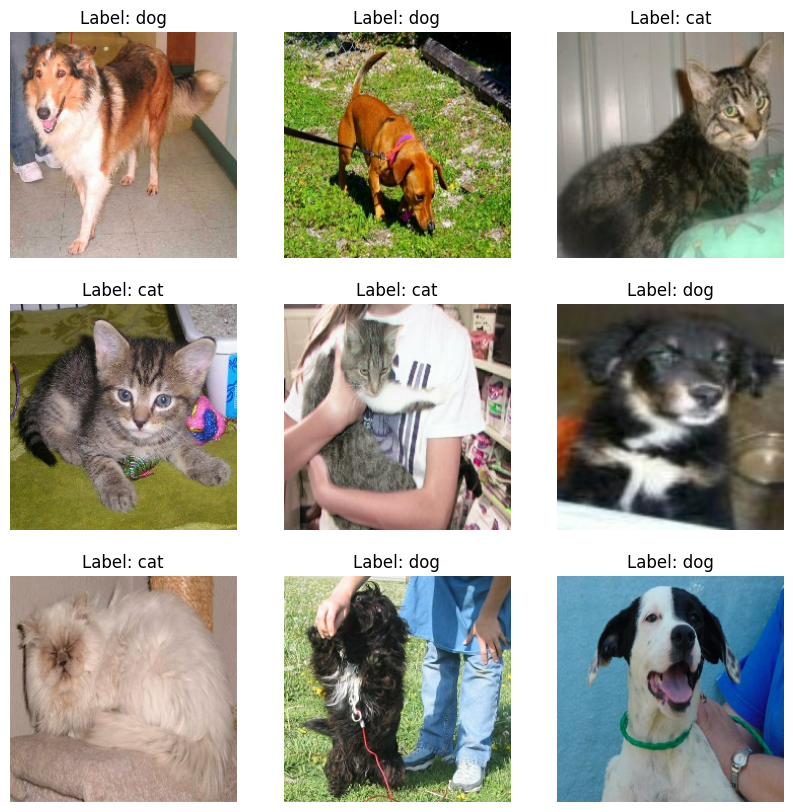

In [5]:
# Pegar um lote de dados do dataset de treinamento processado
# Use take(1) para pegar apenas um lote
for images, labels in dataset_treinamento.take(1):
    # images é um tensor de lote (BATCH_SIZE, altura, largura, canais)
    # labels é um tensor de lote (BATCH_SIZE,) ou (BATCH_SIZE, num_classes) dependendo do formato

    # --- Adicionado para diagnóstico ---
    print("Shape of images batch:", images.shape)
    print("Dtype of images batch:", images.dtype)
    print("Shape of labels batch:", labels.shape)
    print("Dtype of labels batch:", labels.dtype)
    # ----------------------------------

    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 9)): # Mostrar até 9 imagens do lote
        ax = plt.subplot(3, 3, i + 1)

        # --- Adicionado para diagnóstico ---
        print(f"Shape of individual image images[{i}]:", images[i].shape)
        # ----------------------------------

        # tf.keras.utils.array_to_img converte o tensor para um objeto de imagem que o matplotlib pode exibir
        plt.imshow(tf.keras.utils.array_to_img(images[i]))

        # Tentar mostrar o rótulo. O formato do rótulo depende de como você o carregou/processou.
        # Se for one-hot encoded (por exemplo, [0, 0, 1]), você pode encontrar o índice da classe.
        # Se for um número único (por exemplo, 2), mostre o número diretamente.
        # dataset_info precisa estar disponível no escopo para usar features['label'].num_classes
        if 'dataset_info' in locals() and 'label' in dataset_info.features and labels.shape[-1] == dataset_info.features['label'].num_classes: # Assume one-hot e verifica se dataset_info está disponível
             class_index = np.argmax(labels[i])
             # Verifica se int2str está disponível para a feature 'label'
             if hasattr(dataset_info.features['label'], 'int2str'):
                 plt.title(f"Label: {dataset_info.features['label'].int2str(class_index)}")
             else:
                 plt.title(f"Label: {class_index}")
        elif labels.shape.ndims == 0: # Assume rótulo escalar (um único número)
             plt.title(f"Label: {labels[i].numpy()}")
        elif labels.shape.ndims == 1 and labels.shape[0] == BATCH_SIZE: # Assume rótulo numérico em um tensor 1D
             plt.title(f"Label: {labels[i].numpy()}")
        else:
             plt.title("Label: N/A") # Caso o formato do rótulo seja inesperado


        plt.axis("off")
    plt.show()

Aplicando o transfer learning

In [6]:
#importando o modelo VGG16
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

criando um modelo identico ao VGG16 até as duas últimas camadas onde troca para a nossa base de dados menor

In [7]:
# make a reference to VGG's input layer
input_layer = vgg.input

# make a new softmax layer with num_classes neurons
# Use dataset_info to get the number of classes
num_classes = dataset_info.features['label'].num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
output_layer = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(input_layer, output_layer)

Antes de treinar o modelo novo no dataset, precisamos congelar os pesos e os biases em todas as camadas menos a última supondo que as features que o vgg aprendeu são relevantes para a classificação das imagens desse dataset

In [8]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Como antes, vamos treinar o modelo com os mesmos hiper-parâmetros(batch size e epochs)

In [ ]:
# --- Adicionado para diagnóstico ---
print("Diagnóstico antes do fit:")
for images, labels in dataset_treinamento.take(1):
    print("Shape of images batch from dataset:", images.shape)
    print("Dtype of images batch from dataset:", images.dtype)
    print("Shape of labels batch from dataset:", labels.shape)
    print("Dtype of labels batch from dataset:", labels.dtype)
# ----------------------------------

# Converte datasets para arrays NumPy como workaround para erros persistentes com model.fit(tf.data.Dataset)
print("Convertendo datasets para NumPy arrays...")

def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    return np.concatenate(images_list, axis=0), np.concatenate(labels_list, axis=0)

x_treinamento, y_treinamento = dataset_to_numpy(dataset_treinamento)
x_teste, y_teste = dataset_to_numpy(dataset_teste)

print("Datasets convertidos para NumPy arrays.")
print("Shape of x_treinamento:", x_treinamento.shape)
print("Shape of y_treinamento:", y_treinamento.shape)
print("Shape of x_teste:", x_teste.shape)
print("Shape of y_teste:", y_teste.shape)


history = model_new.fit(x_treinamento, y_treinamento,
                         epochs=10,
                         validation_data=(x_teste, y_teste))

Diagnóstico antes do fit:
Shape of images batch from dataset: (32, 224, 224, 3)
Dtype of images batch from dataset: <dtype: 'float32'>
Shape of labels batch from dataset: (32, 2)
Dtype of labels batch from dataset: <dtype: 'float32'>
Convertendo datasets para NumPy arrays...
Datasets convertidos para NumPy arrays.
Shape of x_treinamento: (18610, 224, 224, 3)
Shape of y_treinamento: (18610, 2)
Shape of x_teste: (4652, 224, 224, 3)
Shape of y_teste: (4652, 2)
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 5229s 9s/step - accuracy: 0.7818 - loss: 0.4480 - val_accuracy: 0.9007 - val_loss: 0.2339
Epoch 2/10
337/582 ━━━━━━━━━━━━━━━━━━━━ 29:24 7s/step - accuracy: 0.8926 - loss: 0.2568

plotando a validação da perda e da acurácia

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
#ax.plot(history.history["val_loss"])
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
#ax2.plot(history.history["val_acc"])
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
loss, accuracy = model_new.evaluate(x_teste, y_teste, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
img, x = get_image()
probabilities = model_new.predict([x])